# Graphical Models

Graphical models are graphical representations of conditional depencies between random variables. By merging together *probability theory* and *graph theory*, they provide a direct and compact way to visualize the structure of a model, to motivate the design of new models and to structure complex probability calculations for performing efficient inference. 

We usually distinguish between two types of graphical models:
- **Bayesian Networks** are ideal for modelling *conditional dependencies* between variables and are represented by *directed graphs*;
- **Markov Random Fields** are suitable for modelling *correlations*. In this case the underlying graph is *undirected*.

## Bayesian Networks

A Bayesian networks are Directed Acyclic Graphs (DAG) whose **nodes** represent variables in a Bayesian sense and whose **edges** represent conditional dependencies between variables.

The joint distribution defined by a directed graph is the product, over all the nodes of the graph, of the conditional distributions over the **parent nodes**

$$p(x)=\prod_{k=1}^K p(x_k|\text{parent}_{x_k}).$$

Two nodes $A$ and $B$ in a directed graph are **conditionally independent** given a node $C$  if and only if 

$$p(A,B|C)=p(A|C)p(B|C).$$

This condition is denoted by $A\perp \!\!\! \perp B|C$.

### DAG example

The survey dataset contains informations about usage of different transportation systems, with a focus on cars and trains for different social groups. It includes:

- **Age (A)**: It is recorded as young (young) for individuals below 30 years, adult (adult) for individuals between 30 and 60 years old, and old (old) for people older than 60.
- **Sex (S)**: The biological sex of individual, recorded as male (M) or female (F).
- **Education (E)**: The highest level of education or training completed by the individual, recorded either high school (high) or university degree (uni).
- **Occupation (O)**: It is recorded as an employee (emp) or a self employed (self) worker.
- **Residence (R)**: The size of the city the individual lives in, recorded as small (small) or big (big).
- **Travel (T)**: The means of transport favoured by the individual, recorded as car (car), train (train) or other (other)

Travel is the target of the survey, the quantity of interest whose behaviour is under investigation.
We can represent the relationships between the variables in the survey dataset by a DAG, which describes a factorization of the *joint probability distribution*: 

$$P(A,S,E,O,R,T)=P(A)P(S)P(E|A,S)P(O|E)P(R|E)P(T|O,R).$$

<div> 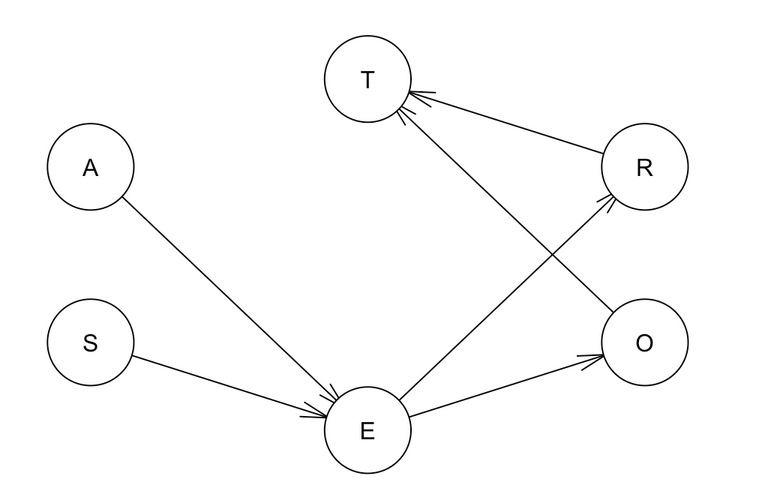</div>

[https://bookdown.org/robertness/causalml/docs/tutorial-probabilistic-modeling-with-bayesian-networks-and-bnlearn.html](https://bookdown.org/robertness/causalml/docs/tutorial-probabilistic-modeling-with-bayesian-networks-and-bnlearn.html)



It is trivial to notice that $R\perp \!\!\! \perp O|E$ and that $R \not\!\perp \!\!\!\perp O|T$.

In fact, $P(R,O,E)=P(R|E)P(O|E)P(E)$ implies 

$$P(R,O|E)=P(R|E)P(O|E),$$

while $P(R,O,T)=P(R)P(O)P(T|R,O)$ and in general $P(T|R,O)\neq P(T)$, so 

$$P(R,O|T)\neq P(R)P(O).$$

### Bayesian Network from Gaussian Mixture

It may happen that the data that we are trying to model presents a complex structure, where multiple regions of the space have a high probability mass (the data has a multimodal distribution).

A **mixture model** is a particular hierarchical model made up by several components, each one with a simple parametric form. It assumes that the data is clustered and that each data point is drawn from a distribution representing the assigned cluster. In a Bayesian setting, the mixture weights and parameters are random variables and the posterior is a conditional distribution over clusterings and parameters. 

In the case of **Gaussian mixtures**, the underlying components are modeled by Gaussians priors:

$$
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(\mu_k,\sigma_k^2)
$$

where $0 \leq \pi_k\leq 1$ and $\sum_{k=1}^K \pi_k = 1$.

<div> 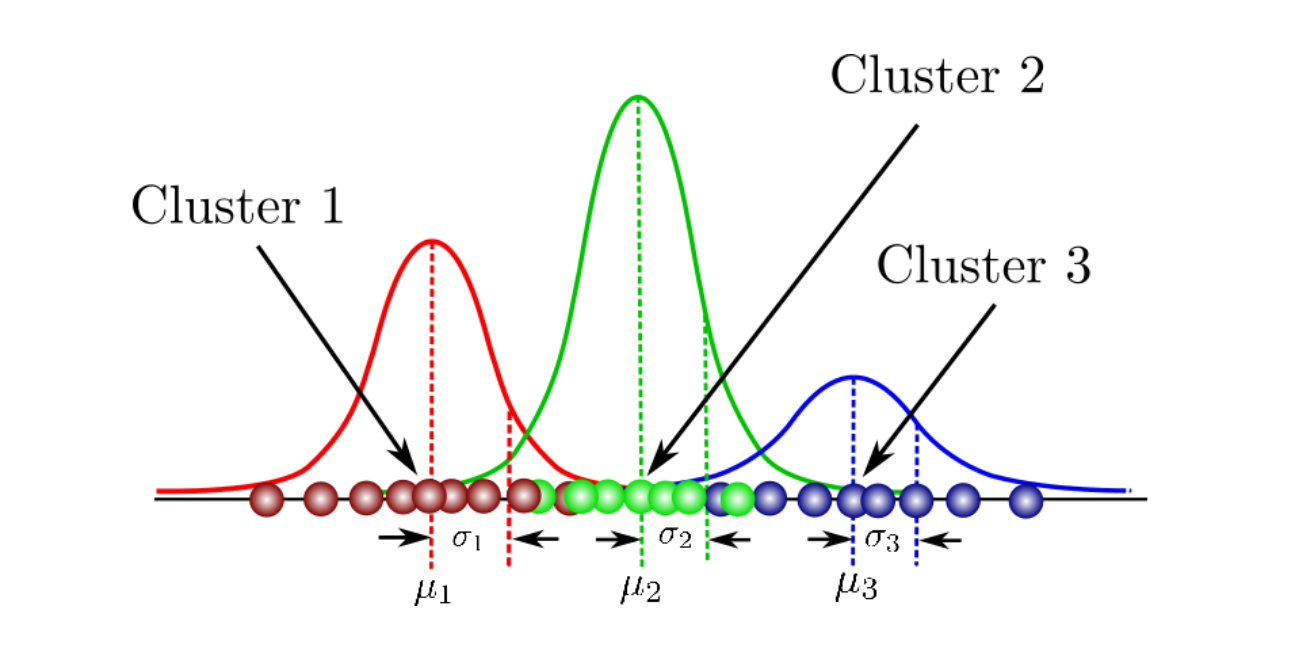</div>

[https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)

In this section we consider a Gaussian mixture model taken from [Blei, "Build, Compute, Critique, Repeat:Data Analysis with Latent Variable Models"](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf),
with the aim of showing that graphical models represent a powerful way to describe how the hidden structure of a model interacts with the observations.

The generative model is:
- $\theta \sim Dirichlet_K(\alpha)$
- $\mu_k \sim \mathcal{N}(0,\sigma_0^2)
$ for the mixture components
- for each data point $i$:
 - $z_i | \theta \sim Categorical(\theta)$
 - $x_i|z_i,\mu_{z_i} \sim \mathcal{N}(\mu_{z_i},1)$


<div> 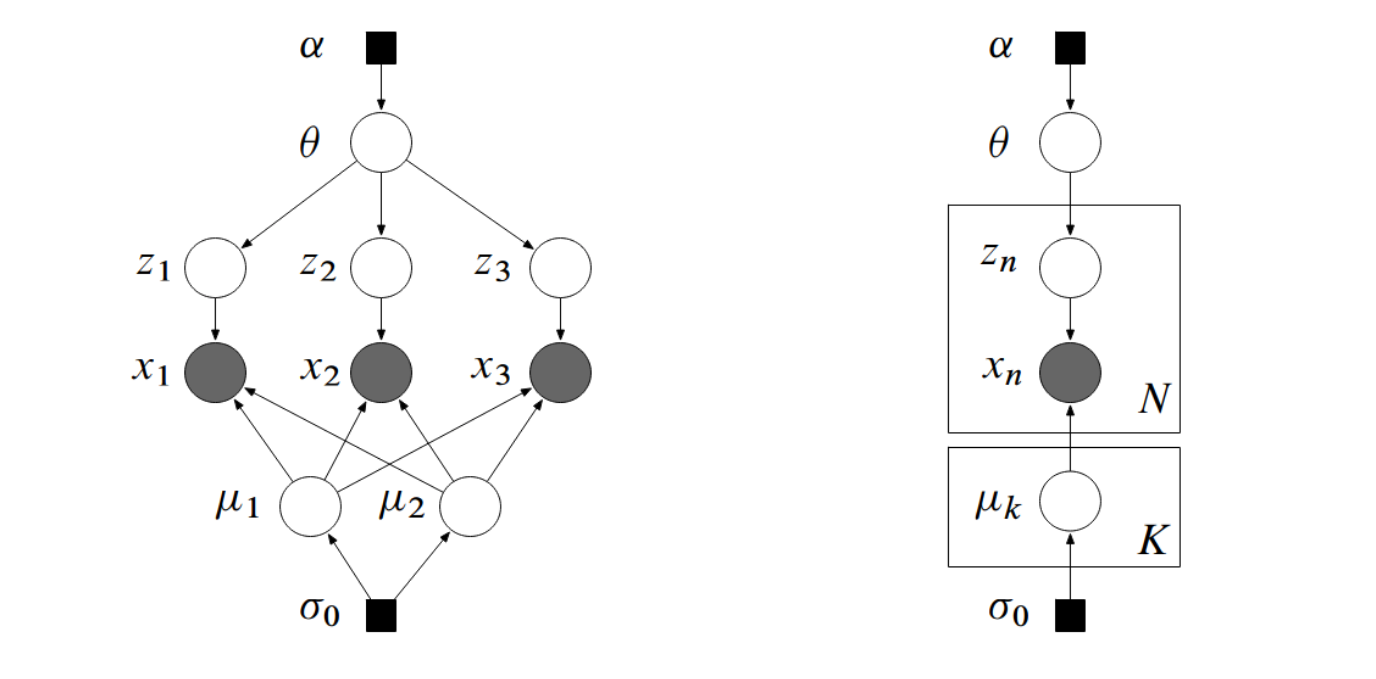</div>

[http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf)

where $\theta, \mu_k, z_i$ are the **hidden variables**, $x_i$ the **observables** and $\alpha, \sigma_0$ the fixed **hyperparameters**. The rightmost figure shows an alternative representation of the same graphical model, using the *plate notation* on random vectors.

The joint distribution factorizes as
$$p(\theta,\mu,z,x|\sigma_0,\alpha) = p(\theta|\alpha)\prod_{k=1}^K p(\mu_k|\sigma_0)\prod_{i=1}^N[p(z_i|\theta)p(x_i|z_i,\mu_k)].$$

From this representation the identification of *global* and *local* variables comes easy:
the first ones describe the hidden structure (which is shared for the entire dataset) and the latter ones only regard the distribution of single observations.

The posterior distribution, given the observations, is

$$p(\theta,\mu,z|x,\sigma_0,\alpha)=\frac{p(\theta,\mu,z,x|\sigma_0,\alpha)}{p(x|\sigma_0,\alpha)}.$$


**Pyro implementation**

In [1]:
import pyro
import torch
import pyro.distributions as dist

Pytorch computations operate on multidimensional arrays called **tensors**. Pytorch provides a wide variety of optimized tensor routines which can be run both on CPU and GPU, such as slicing, indexing, math operations, linear algebra, reductions. 

In [2]:
# number of components
K = 2 

# hyperparameters
alpha = 0.5
sigma_0 = 10.0

def model(data):
    N = len(data)
    
    # Global variables
    theta = pyro.sample('theta', dist.Dirichlet(alpha * torch.ones(K)))
    
    with pyro.plate('components', K):
        mu = pyro.sample('mu', dist.Normal(0., sigma_0))
        
    with pyro.plate('data', N):
        # Local variables
        z = pyro.sample('z', dist.Categorical(probs=theta))
        x = pyro.sample('x', dist.Normal(mu[z], 1), obs=data)
    
    print("theta =",theta,"\nmu =",mu,"\nz =", z,"\nx =",  x)
    
model(data=[7, 0.8, 0.1, 6, 0.5, 6.8])

theta = tensor([0.9325, 0.0675]) 
mu = tensor([13.8951,  6.1454]) 
z = tensor([0, 0, 0, 0, 0, 0]) 
x = [7, 0.8, 0.1, 6, 0.5, 6.8]


`pyro.plate()` method guarantees that all computations within a `plate` are **conditionally independent**

```
with pyro.plate("tensor name", tensor size):
    # ...do conditionally independent stuff ...
```

## Markov Random Fields

A Markov random field is an undirected graphical model, whose **nodes** correspond to variables and whose **edges** represent conditional dependences between variables.

Any two nodes that are not connected by a direct edge (not adjacent) are **conditionally independent** given all the other nodes in the graph. 

The factorization rule for undirected graphs is based on the notion of **cliques**: they are complete subgraphs of the original graph, meaning that all pairs of nodes are connected by a unique edge. Maximal cliques are cliques that cannot be further extended without them stopping being cliques. 

<div> 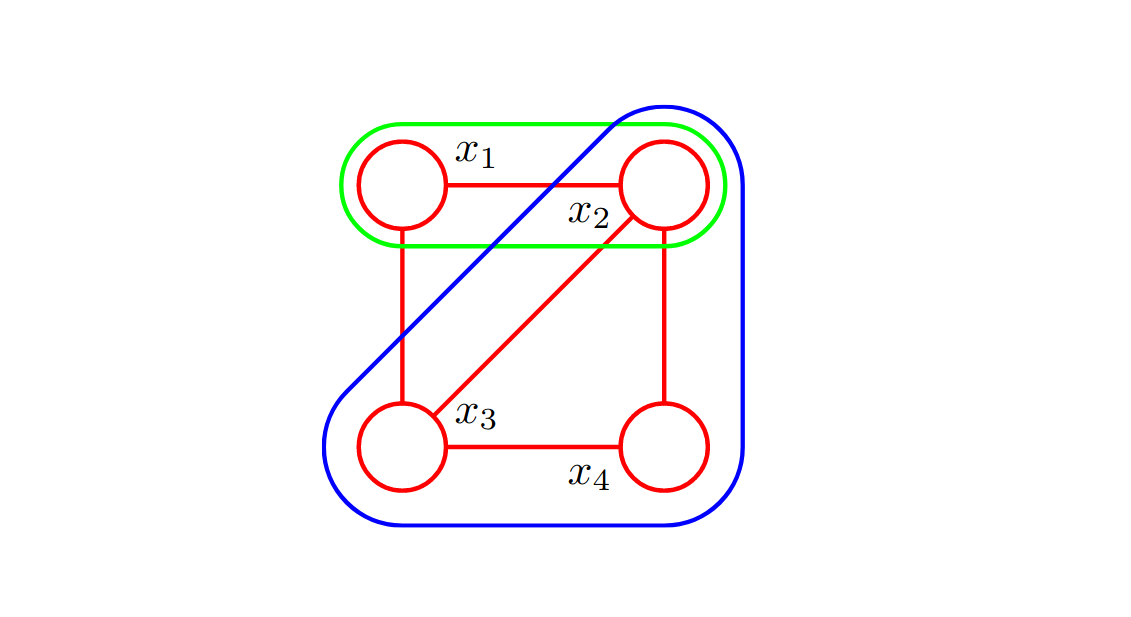</div>
<div style="color:darkblue">C. M. Bishop, "Pattern Recognition and Machine Learning"</div>

The joint distribution factorizes as the product of *potential functions* 

$$\psi_C(x_C)=\exp^{-E(x_C)},$$

over the maximal cliques of the graph 

$$p(x)=\frac{1}{Z}\prod_C \psi_C(x_C),$$

where potentials are defined in terms of an *energy* function $E$ and the normalization constant for the joint distirbution is $Z=\sum_x\prod_C\psi_C(x_C)$.



### Ising model for binary image denoising 

MRF applications in computer vision include image segmentation, image completion and image denoising. In all such cases they are used to impose smoothness constraints on the neighboring pixels.

The **Ising model** assumes that we have a grid of nodes, where each node can be in one of two states. In the case of binary images, you can think of each node as being a pixel with a black or white color.
The state of each node depends on the neighboring nodes through interaction potentials, which impose the smoothness constraint over pixels.

Assume that we have a 2D grid of binary noisy pixel observations of an underlying true image and we would like to recover the original image. Suppose that $x_i$ is a binary variable denoting the state of pixel $i$ in the unknown original image, while $y_i$ represents the corresponding state in the observed noisy image. 

<div> 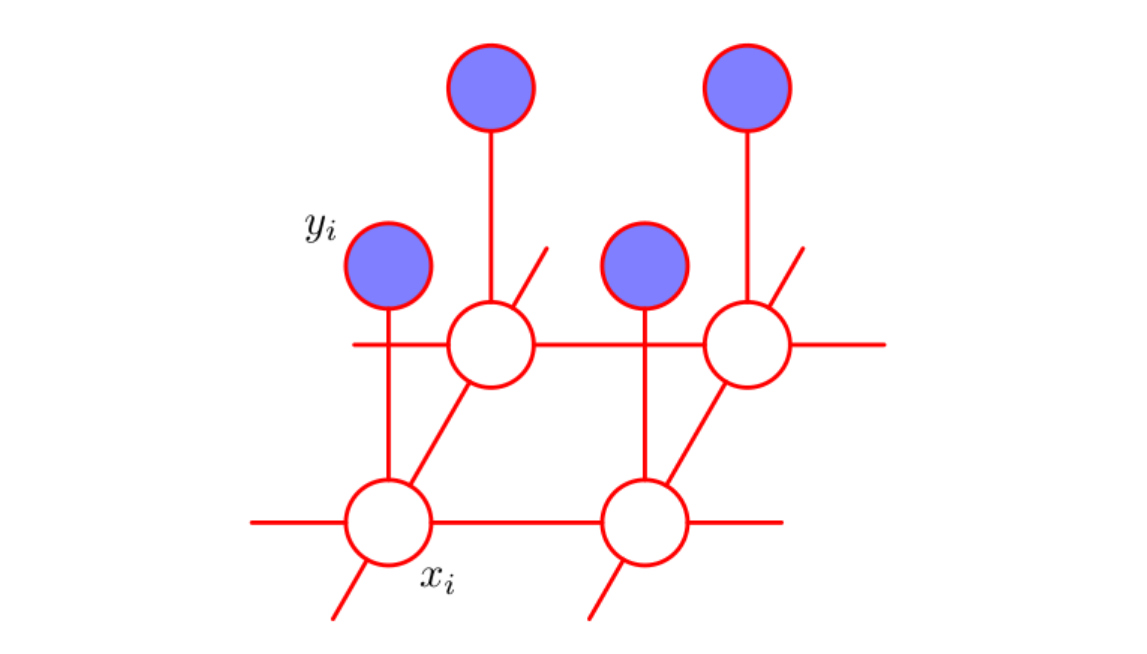</div>
<div style="color:darkblue">C. M. Bishop, "Pattern Recognition and Machine Learning"</div>

We shall suppose that both $x_i,y_i\in\{-1,+1\}$ and that the noisy image was obtained by randomly flipping the sign of pixels with some small probability, say $10\%$. 
Since the added noise is small, we expect to find a strong correlation between $x_i$ and $y_i$, and between neighbouring pixels $x_i,x_j$. We have two possible cliques, on which we can define the following potential functions:
- $-\eta x_i y_i$, where $\eta>0$, for $\{x_i,y_i\}$ cliques
- $-\beta x_i x_j$, where $\beta>0$, for $\{x_i,x_j\}$ cliques

Consequently, the **energy** function for the Ising model becomes 

$$E(x,y)=-\beta\sum_{i,j}x_i x_j-\eta \sum_{i}x_i y_i$$

and the associated joint distribution is 

$$p(x,y)=\frac{1}{Z}\exp^{-E(x,y)}.$$

For the purposes of image denoising, we wish to find an image
having a high probability. We shall use a simple iterative technique called **Iterated conditional modes** (ICM) and defined as follows:
- initialize the variables $x_i=y_i$
- for each node $j$:
    - evaluate the energy function on $x_j$ for the two possible states, while keeping the other node variables fixed
    - set $x_j$ to the lower energy (higher probability) state

We repeat the ICM steps for a fixed number of iterations.

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import cm

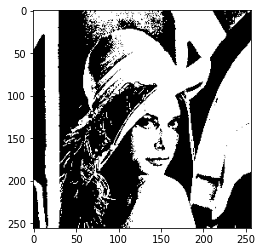

In [4]:
image = mpimg.imread('data/lena.png')[:,:,0]
image = np.where(image>0.5,-1,1)
plt.imshow(image, cmap = cm.Greys)

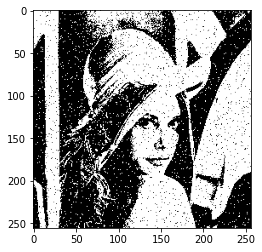

In [5]:
noise = np.zeros((image.shape))

with pyro.plate('pixels', 256*256):
    noise = pyro.sample('mu', dist.Normal(1., 0.5)).reshape(256,256)
    
noisy = np.where(noise<0.1,-1,1)
noisy_image = image*noisy
plt.imshow(noisy_image, cmap = cm.Greys)

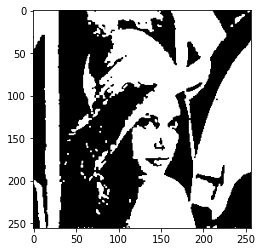

In [6]:
beta = 1.2
eta = 1.8

for iteration in range(0,3):
    
    # pixel idxs
    for i in range(0,255):
        for j in range(0,255):
            
            # potentials
            beta_factor = 0 # cliques between neighbors
            eta_factor = 0 # cliques between latent and observed values
            
            # positive state energy
            x_i = 1
            y_i = noisy_image[i][j]

            if i-1 >= 0:
                beta_factor += noisy_image[i-1][j]*x_i
            if i+1 < 256:
                beta_factor += noisy_image[i+1][j]*x_i
            if j-1 >= 0:
                beta_factor += noisy_image[i][j-1]*x_i
            if j+1 < 256:
                beta_factor += noisy_image[i][j+1]*x_i
            
            eta_factor = x_i*y_i
            pos_state_energy = - beta*beta_factor - eta*eta_factor
            
            # negative state energy 
            beta_factor = 0
            eta_factor = 0
            x_i = -1
            
            if i-1 >= 0:
                beta_factor += noisy_image[i-1][j]*x_i
            if i < 256:
                beta_factor += noisy_image[i+1][j]*x_i
            if j-1 >= 0:
                beta_factor += noisy_image[i][j-1]*x_i
            if j < 256:
                beta_factor += noisy_image[i][j+1]*x_i
                
            eta_factor = x_i*y_i
            neg_state_energy =  - beta*beta_factor - eta*eta_factor

            # choose lower energy state
            image[i][j] = 1 if pos_state_energy < neg_state_energy else -1

    noisy_image = image

imgplot = plt.imshow(image, cmap = cm.Greys)
plt.show()

## References
- [R. Ness "Lecture Notes for Causality in Machine Learning"](https://bookdown.org/robertness/causalml/docs/)
- [D. Blei, "Build, Compute, Critique, Repeat:Data Analysis with Latent Variable Models"](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf)
- [R. Grosse, N. Srivastava, "Mixture models"](http://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf)
- C. M. Bishop, "Pattern Recognition and Machine Learning"